# Cluster Analysis in Spark

In [64]:
import pyspark
from pyspark.sql import SQLContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
# from pyspark.ml.stat import Correlation
from pyspark.sql.functions import *
import utils
%matplotlib inline

In [4]:
sc = pyspark.SparkContext()

23/04/11 16:39:52 WARN Utils: Your hostname, ubuntu resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
23/04/11 16:39:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/11 16:39:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


The minute weather dataset comes from the same source as the daily weather dataset that was used for the hands-on activities in the previous modules.  The difference is that the minute weather dataset contains raw sensor measurements captured at one-minute intervals, not processed like the daily weather dataset.  The data is in the file minute_weather.csv, which  is a comma-separated file.  

As with the daily weather data, this data comes from a weather station located in San Diego, California.  The weather station is equipped with sensors that capture weather-related measurements such as air temperature, air pressure, and relative humidity.  Data was collected for a period of three years, from September 2011 to September 2014, to ensure that sufficient data for different seasons and weather conditions is captured.

Each row in minute_weather.csv contains weather data captured for a one-minute interval.  Each row, or sample, consists of the following variables:

In [20]:
import pandas
pandas.set_option('display.max_colwidth', None)
data_description = pandas.read_clipboard()
data_description

,Variable,Description,Unit of Measure
0,rowID,unique number for each row,NaN
1,hpwren_timestamp,timestamp of measure,year-month-day hour:minute:second
2,air_pressure,air pressure measured at the timestamp,hectopascals
3,air_temp,air temperature measure at the timestamp,degrees Fahrenheit
4,avg_wind_direction,wind direction averaged over the minute before the timestamp,"degrees, with 0 means coming from the North, and increasing clockwise"
5,avg_wind_speed,wind speed averaged over the minute before the timestamp,meters per second
6,max_wind_direction,highest wind direction in the minute before the timestamp,"degrees, with 0 being North and increasing clockwise"
7,max_wind_speed,highest wind speed in the minute before the timestamp,meters per second
8,min_wind_direction,smallest wind direction in the minute before the timestamp,"degrees, with 0 being North and inceasing clockwise"
9,min_wind_speed,smallest wind speed in the minute before the timestamp,meters per second


In [21]:
!ls

01_data-exploration.ipynb	  04_model-evaluation.ipynb  __pycache__
02_handling-missing-values.ipynb  05_clustering.ipynb	     utils.py
03_classification.ipynb		  predictions.csv


In [24]:
data_description.to_csv('data_description.csv')

In [26]:
!ls

01_data-exploration.ipynb	  04_model-evaluation.ipynb  predictions.csv
02_handling-missing-values.ipynb  05_clustering.ipynb	     __pycache__
03_classification.ipynb		  data_description.csv	     utils.py


In [27]:
sqlContext = SQLContext(sc)
df = sqlContext.read.load('file:///home/hadoop/big-data-processing/data/minute_weather.csv', 
                          format='com.databricks.spark.csv', 
                          header='true',inferSchema='true')

/home/hadoop/anaconda3/lib/python3.10/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## Problem Description
We go through the process of performing cluster analysis on a dataset using k-means.  In this activity, we will perform cluster analysis on the minute-weather.csv dataset using the k-means algorithm.  

This dataset contains weather measurements such as temperature, relative humidity, etc., from a weather station in San Diego, California, collected at one-minute intervals.  The goal of cluster analysis on this data is to identify different weather patterns for this weather station.

In [28]:
df.count()

1587257

In [34]:
df.printSchema()

root
 |-- rowID: integer (nullable = true)
 |-- hpwren_timestamp: timestamp (nullable = true)
 |-- air_pressure: double (nullable = true)
 |-- air_temp: double (nullable = true)
 |-- avg_wind_direction: double (nullable = true)
 |-- avg_wind_speed: double (nullable = true)
 |-- max_wind_direction: double (nullable = true)
 |-- max_wind_speed: double (nullable = true)
 |-- min_wind_direction: double (nullable = true)
 |-- min_wind_speed: double (nullable = true)
 |-- rain_accumulation: double (nullable = true)
 |-- rain_duration: double (nullable = true)
 |-- relative_humidity: double (nullable = true)



There are over 1.5 million rows in the DataFrame. Clustering this data on your computer in the Ubuntu LTS 22.04 VM can take a long time, so let's only one-tenth of the data. We can subset by calling filter() and using the rowID column:

In [29]:
filteredDF = df.filter((df.rowID % 10) == 0)
filteredDF.count()

158726

In [30]:
filteredDF.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
rowID,158726,793625.0,458203.9375103623,0,1587250
air_pressure,158726,916.830161410252,3.051716552831359,905.0,929.5
air_temp,158726,61.85158915363659,11.833569210641672,31.64,99.5
avg_wind_direction,158680,162.15610032770354,95.27820101905958,0.0,359.0
avg_wind_speed,158680,2.7752148979077376,2.0576239697426337,0.0,31.9
max_wind_direction,158680,163.46214393748426,92.452138538387,0.0,359.0
max_wind_speed,158680,3.4005577262415194,2.4188016208098855,0.1,36.0
min_wind_direction,158680,166.77401688933702,97.44110914784576,0.0,359.0
min_wind_speed,158680,2.1346641038569323,1.7421125052424373,0.0,31.6


The weather measurements in this dataset were collected during a drought in San Diego. We can count the how many values of rain accumulation and duration are 0:

In [31]:
filteredDF.filter(filteredDF.rain_accumulation == 0.0).count() 

157812

In [32]:
filteredDF.filter(filteredDF.rain_duration == 0.0).count() 

157237

Since most the values for these columns are 0, let's drop them from the DataFrame to speed up our analyses. We can also drop the hpwren_timestamp column since we do not use it.

In [33]:
workingDF = filteredDF.drop('rain_accumulation').drop('rain_duration').drop('hpwren_timestamp')

Let's drop rows with missing values and count how many rows were dropped:

In [35]:
before = workingDF.count()
workingDF = workingDF.na.drop()
after = workingDF.count()
before - after

46

**Scale the data.** Since the features are on different scales (e.g., air pressure values are in the 900’s, while relative humidities range from 0 to 100), they need to be scaled.  We will scale them so that each feature will have a value of 0 for the mean, and a value of 1 for the standard deviation.

First, we will combine the columns into a single vector column. Let's look at the columns in the DataFrame:

In [58]:
workingDF.columns

['rowID',
 'air_pressure',
 'air_temp',
 'avg_wind_direction',
 'avg_wind_speed',
 'max_wind_direction',
 'max_wind_speed',
 'min_wind_direction',
 'min_wind_speed',
 'relative_humidity']

We do not want to include rowID since it is the row number. The minimum wind measurements have a high correlation to the average wind measurements, so we will not include them either. Let's create an array of the columns we want to combine, and use VectorAssembler to create the vector column:

In [65]:
workingDF.stat.corr('avg_wind_speed', 'min_wind_speed')

0.9708621148272663

In [37]:
featuresUsed = ['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 
        'max_wind_speed','relative_humidity']
assembler = VectorAssembler(inputCols=featuresUsed, outputCol="features_unscaled")
assembled = assembler.transform(workingDF)

Let's use StandardScaler to scale the data:

In [38]:
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withStd=True, withMean=True)
scalerModel = scaler.fit(assembled)
scaledData = scalerModel.transform(assembled)

The `withMean` argument specifies to center the data with the mean before scaling, and `withStd` specifies to scale the data to the unit standard deviation.

**Create elbow plot.** The k-means algorithm requires that the value of $k$, the number of clusters, to be specified.  To determine a good value for $k$, we will use the “elbow” method.  This method involves applying $k$-means, using different values for $k$, and calculating the within-cluster sum-of-squared error (WSSE). 

Since this means applying $k$-means multiple times, this process can be very compute-intensive.  To speed up the process, we will use only a subset of the dataset.  We will take every third sample from the dataset to create this subset:

In [39]:
scaledData = scaledData.select("features", "rowID")

elbowset = scaledData.filter((scaledData.rowID % 3) == 0).select("features")
elbowset.persist()

DataFrame[features: vector]

The last line calls the `persist()` method to tell Spark to keep the data in memory (if possible), which will speed up the computations.

We compute the $k$-means clusters for $k$ = 2 to 30 to create an elbow plot:

In [40]:
clusters = range(2,31)
wsseList = utils.elbow(elbowset, clusters)

Training for cluster size 2 


/home/hadoop/anaconda3/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/hadoop/anaconda3/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


......................WSSE = 117228.9979233905 
Training for cluster size 3 


/home/hadoop/anaconda3/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/hadoop/anaconda3/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


......................WSSE = 103495.35420742206 
Training for cluster size 4 


......................WSSE = 94586.68234188115 
Training for cluster size 5 


......................WSSE = 91139.2667956011 
Training for cluster size 6 


......................WSSE = 85087.2210236736 
Training for cluster size 7 


......................WSSE = 81832.63278657752 
Training for cluster size 8 


......................WSSE = 79377.41489112313 
Training for cluster size 9 


......................WSSE = 76637.98160500702 
Training for cluster size 10 


......................WSSE = 74021.78447395912 
Training for cluster size 11 


......................WSSE = 73935.48341630568 
Training for cluster size 12 


......................WSSE = 69819.66134223137 
Training for cluster size 13 


......................WSSE = 68848.32891230956 
Training for cluster size 14 


......................WSSE = 67627.48956805709 
Training for cluster size 15 


......................WSSE = 66461.56191461303 
Training for cluster size 16 


......................WSSE = 65246.234936961024 
Training for cluster size 17 


......................WSSE = 64966.98519072209 
Training for cluster size 18 


......................WSSE = 63379.32754880126 
Training for cluster size 19 


......................WSSE = 63181.63151660882 
Training for cluster size 20 


......................WSSE = 62655.58057718666 
Training for cluster size 21 


......................WSSE = 61940.89165804384 
Training for cluster size 22 


......................WSSE = 61636.09310278753 
Training for cluster size 23 


......................WSSE = 60147.53797086056 
Training for cluster size 24 


......................WSSE = 59850.66452030731 
Training for cluster size 25 


......................WSSE = 58994.17933624241 
Training for cluster size 26 


......................WSSE = 58912.03434472544 
Training for cluster size 27 


......................WSSE = 58470.10083809079 
Training for cluster size 28 


......................WSSE = 57645.476041717026 
Training for cluster size 29 


......................WSSE = 57338.470643235974 
Training for cluster size 30 


......................WSSE = 56912.18733702838 


The first line creates an array with the numbers 2 through 30, and the second line calls the `elbow()` function defined in the `utils.py` library to perform clustering. The first argument to `elbow()` is the dataset, and the second is the array of values for $k$. The `elbow()` function returns an array of the WSSE for each number of clusters.

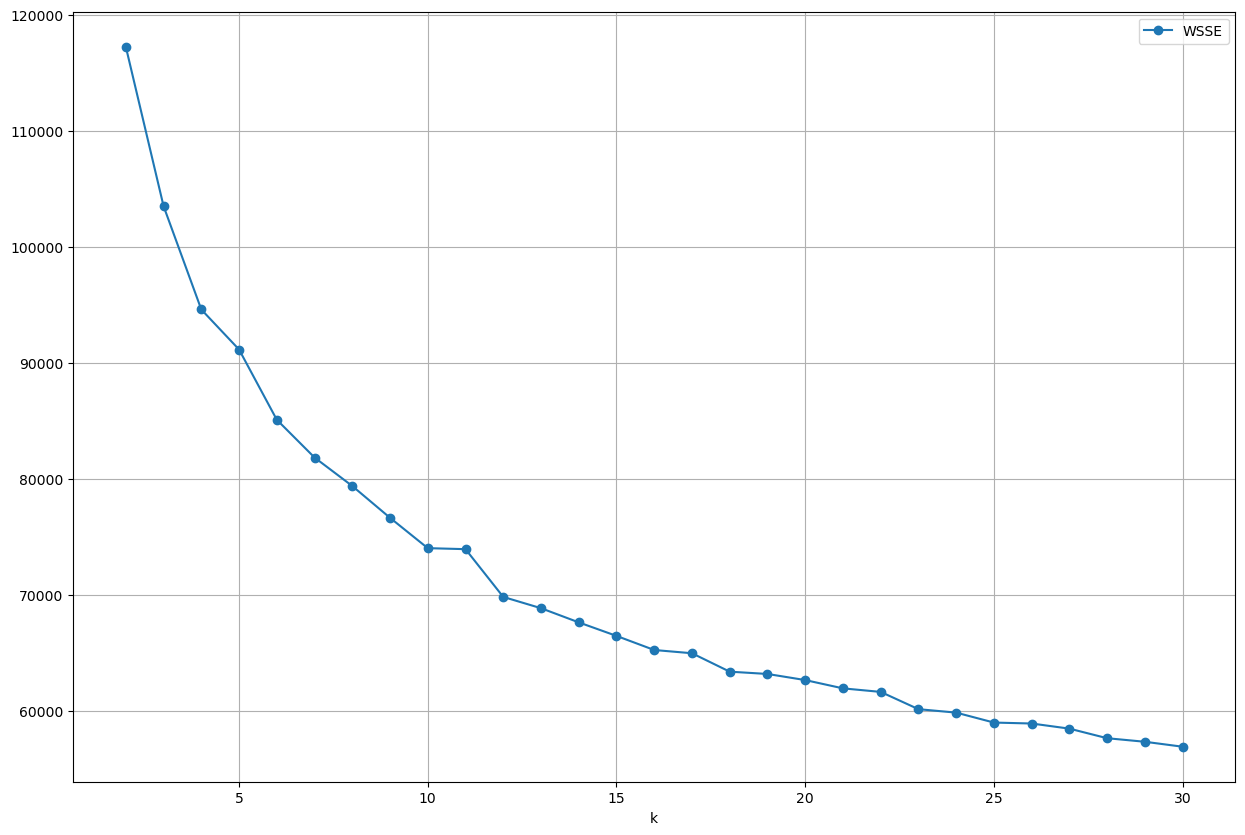

In [41]:
utils.elbow_plot(wsseList, clusters)

The values for k are plotted against the WSSE values, and the elbow, or bend in the curve, provides a good estimate for the value for $k$.  In this plot, we see that the elbow in the curve is between 10 and 15, so let's choose $k = 12$.  We will use this value to set the number of clusters for $k$-means.

Cluster using selected $k$. Let's select the data we want to cluster:

Again, we call the `persist()` method to cache the data in memory for faster access.

In [42]:
scaledDataFeat = scaledData.select("features")
scaledDataFeat.persist()

DataFrame[features: vector]

In [43]:
kmeans = KMeans(k=12, seed=1)
model = kmeans.fit(scaledDataFeat)
transformed = model.transform(scaledDataFeat)

The first line creates a new KMeans instance with 12 clusters and a specific seed value.\
The second line fits the data to the model, and the third applies the model to the data.

Once the model is created, we can determine the center measurement of each cluster:

In [44]:
centers = model.clusterCenters()
centers

[array([ 0.31193071, -1.10515968, -1.20684724, -0.5740194 , -1.03920901,
        -0.57936301,  1.07993424]),
 array([ 0.23351408,  0.32066637,  1.88802599, -0.65182056, -1.55151455,
        -0.57651829, -0.2838673 ]),
 array([ 0.30948763,  0.75917911,  1.32559394, -0.63411172,  1.58966255,
        -0.58502263, -0.73899788]),
 array([-0.4338757 ,  0.11613187, -1.17258135, -0.56598772, -1.0498596 ,
        -0.59604043,  0.13662035]),
 array([ 1.44246571, -0.12062683, -1.10201792, -0.09949119, -0.96071048,
        -0.07920465, -0.98449415]),
 array([-1.16139016, -0.83731699,  0.44626299,  1.99066016,  0.5364939 ,
         1.94811864,  0.88038539]),
 array([-0.17202135,  0.61782603,  0.4090396 ,  0.65260512,  0.51893837,
         0.59598055, -0.17946092]),
 array([ 1.18470473, -0.24914106, -1.15442856,  2.09796054, -1.05220352,
         2.21392217, -1.13276907]),
 array([-0.88341971, -1.17891884,  0.37201834,  0.38661636,  0.47274197,
         0.37361112,  1.34268906]),
 array([-0.23216221

It is difficult to compare the cluster centers by just looking at these numbers. So we will use plots in the next step to visualize them. 

**Create parallel plots of clusters and analysis.** A parallel coordinates plot is a great way to visualize multi-dimensional data.\
Each line plots the centroid of a cluster, and all of the features are plotted together. Recall that the feature values were scaled to have mean = 0 and standard deviation = 1. So the values on the y-axis of these parallel coordinates plots show the number of standard deviations from the mean.  For example, +1 means one standard deviation higher than the mean of all samples, and -1 means one standard deviation lower than the mean of all samples.

We'll create the plots with matplotlib using a Pandas DataFrame each row contains the cluster center coordinates and cluster label. (Matplotlib can plot Pandas DataFrames, but not Spark DataFrames.) Let's use the pd_centers() function in the utils.py library to create the Pandas DataFrame:

In [45]:
P = utils.pd_centers(featuresUsed, centers)

## Dry Days

Let's show clusters for "Dry Days",  i.e., weather samples with low relative humidity:

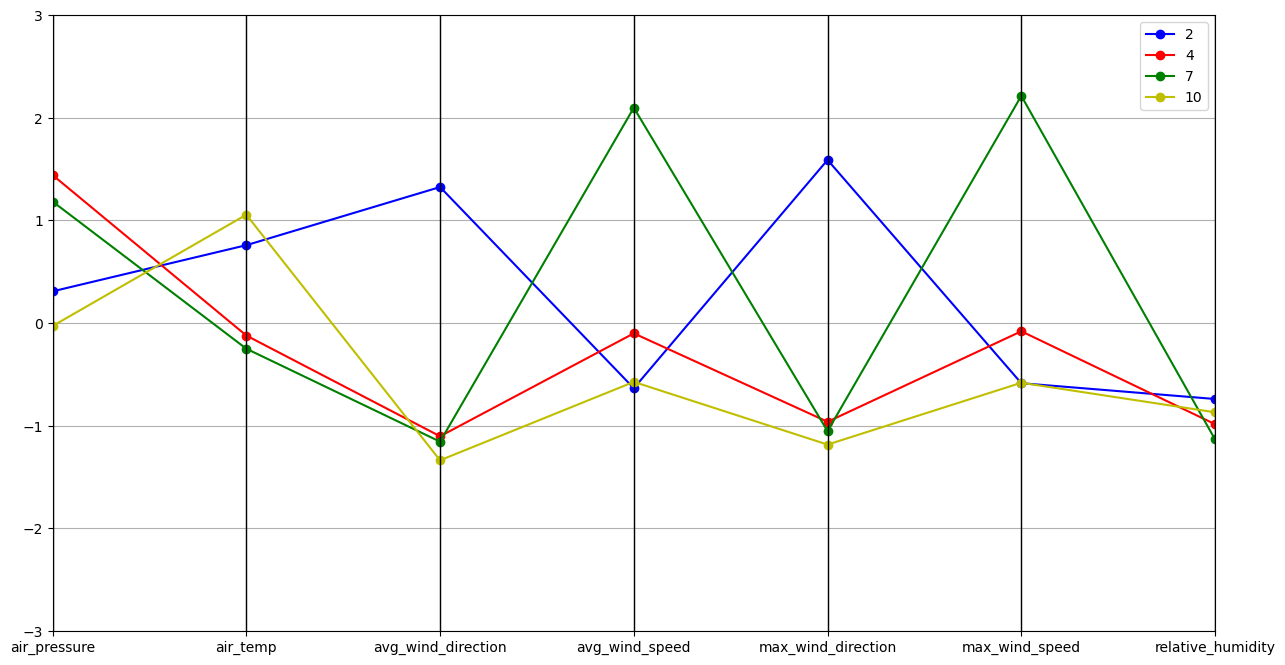

In [46]:
utils.parallel_plot(P[P['relative_humidity'] < -0.5], P)

The first argument to parallel_plot selects the clusters whose relative humidities are centered less than 0.5 from the mean value. All clusters in this plot have relative_humidity < -0.5, but they differ in values for other features, meaning that there are several weather patterns that include low humidity.

Note in particular cluster 7.  This cluster has samples with lower-than-average wind direction values.  Recall that wind direction values are in degrees, and 0 means wind coming from the North and increasing clockwise.  So samples in this cluster have wind coming from the N and NE directions, with very high wind speeds, and low relative humidity. These are characteristic weather patterns for Santa Ana conditions, which greatly increase the dangers of wildfires.

## Warm Days

Let's show clusters for "Warm Days", i.e., weather samples with high air temperature:

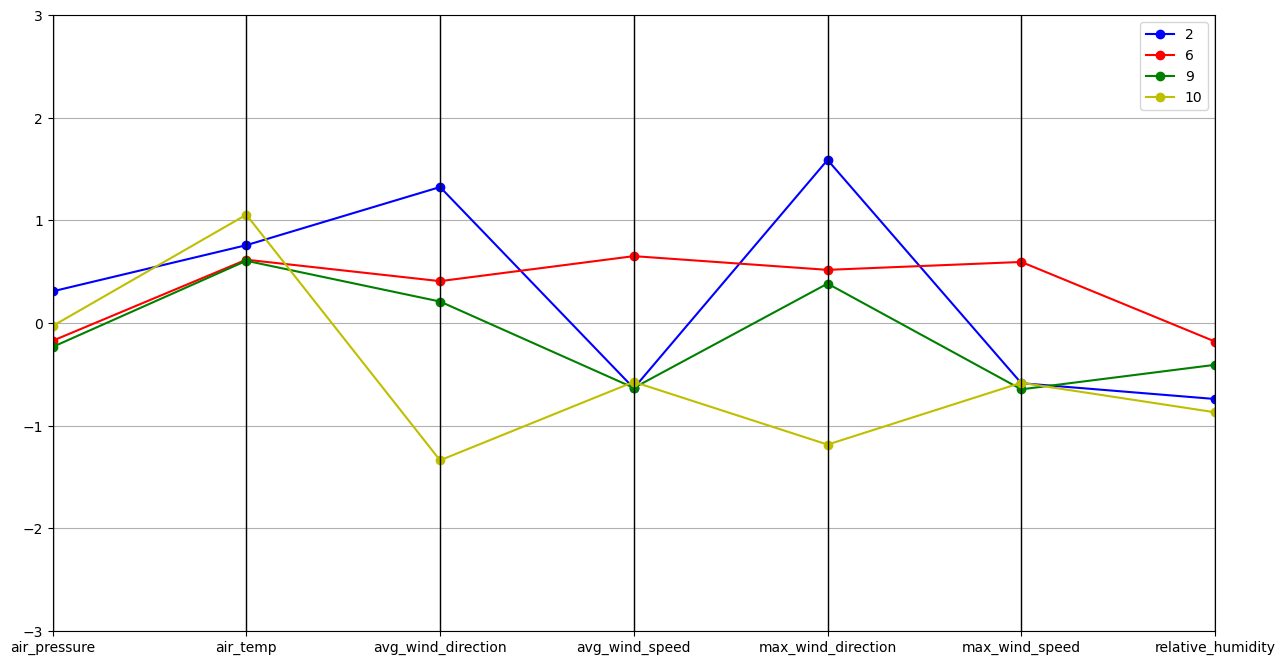

In [47]:
utils.parallel_plot(P[P['air_temp'] > 0.5], P)

All clusters in this plot have air_temp > 0.5, but they differ in values for other features.

## Cool Days

Let's show clusters for "Cool Days", i.e., weather samples with high relative humidity and low air temperature:

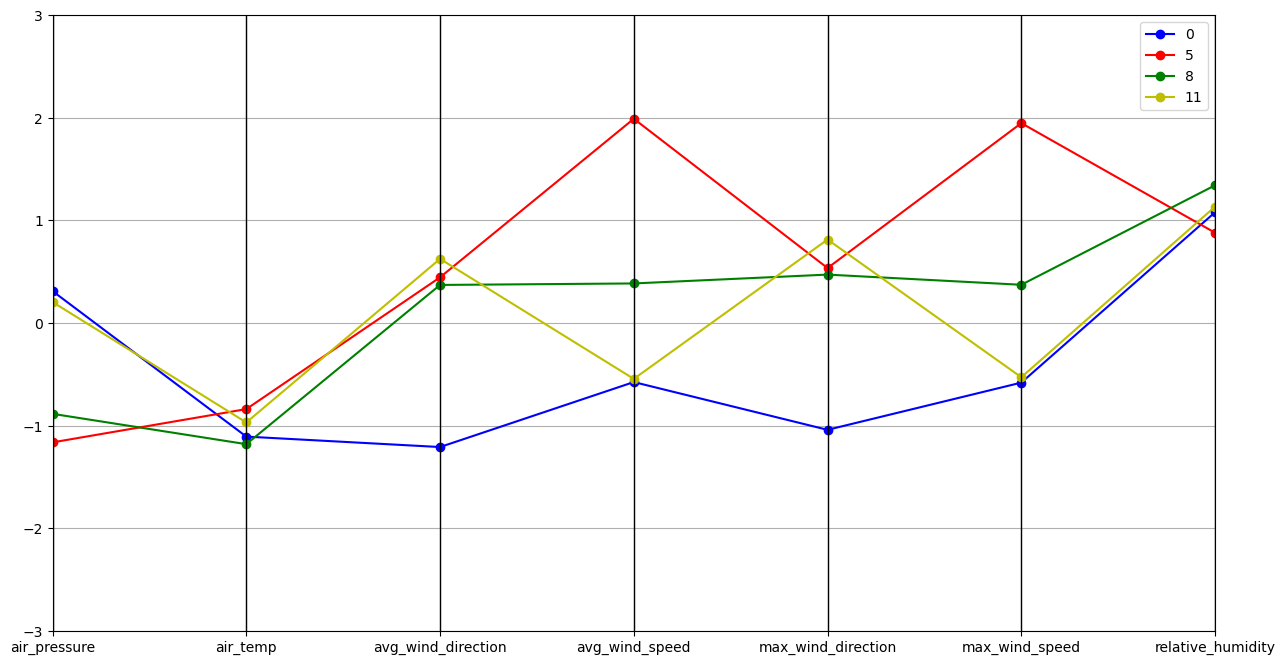

In [48]:
utils.parallel_plot(P[(P['relative_humidity'] > 0.5) & (P['air_temp'] < 0.5)], P)

All clusters in this plot have relative_humidity > 0.5 and air_temp < 0.5.  These clusters represent cool temperature with high humidity and possibly rainy weather patterns.  For cluster 5, note that the wind speed values are high, suggesting stormy weather patterns with rain and wind.

## Other Days

So far, we've seen all the clusters except 3 & 1 since it did not fall into any of the other categories. Let's plot this cluster:

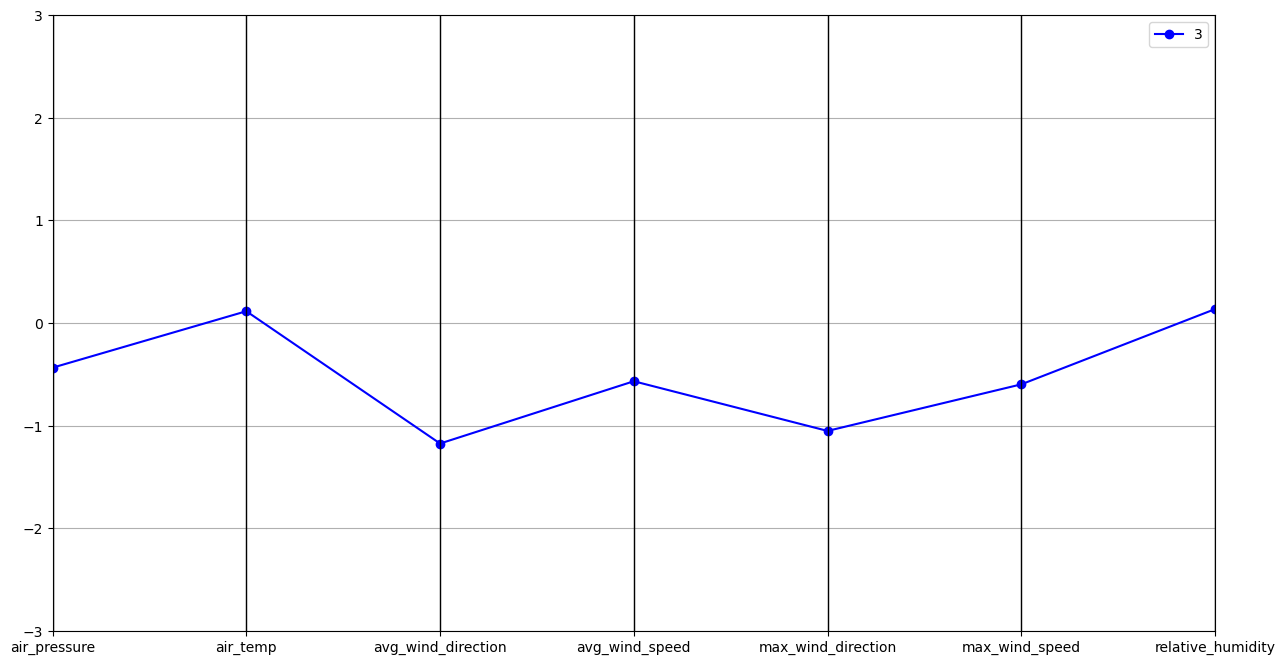

In [52]:
utils.parallel_plot(P.iloc[[3]], P)

Cluster 3 captures days with mild weather.

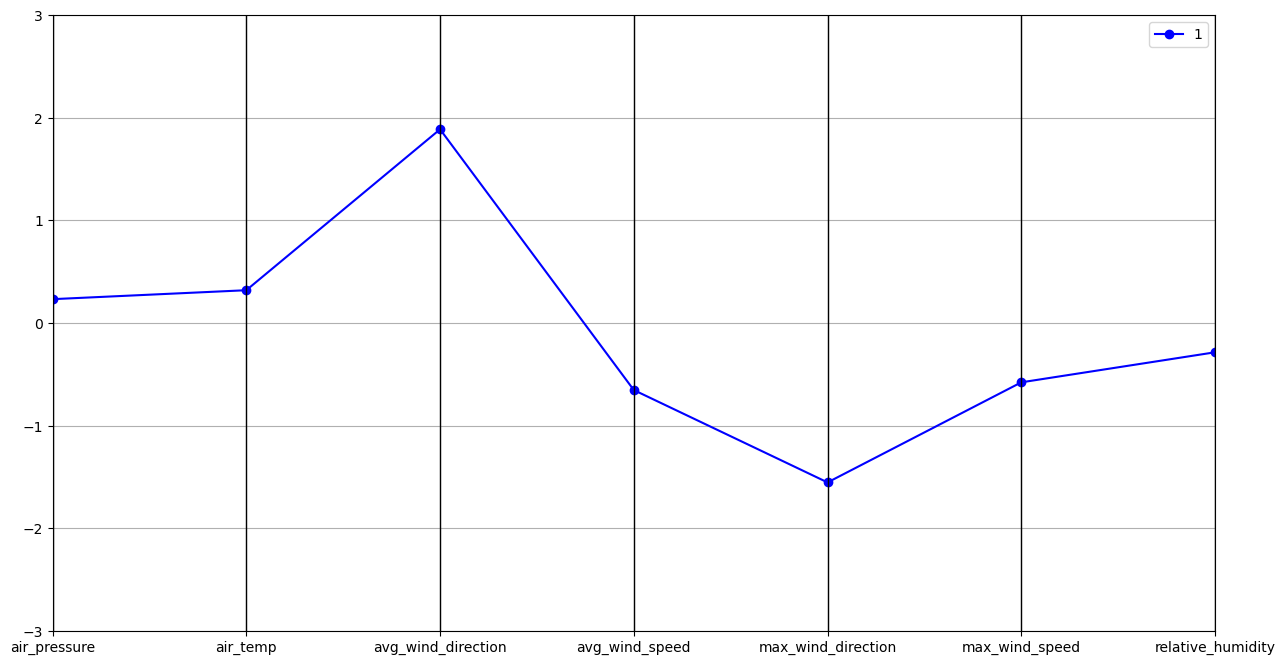

In [53]:
utils.parallel_plot(P.iloc[[1]], P)